# [ node2vec implementation ]
- with Football dataset

# 1. Import Dataset  & Libraries

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

%matplotlib inline

In [2]:
H = nx.read_gml('football.gml')

adjacent matrix & one-hot encoded matrix

In [3]:
A = nx.to_numpy_matrix(H,nodelist=H.nodes())

In [4]:
OH = np.identity(A.shape[0])

# 2. Define functions

#### 1) softmax

In [5]:
def softmax(x):
    c = np.max(x)
    b = x-c
    exp_x = np.exp(b)
    sum_exp_x = np.sum(exp_x)
    y = exp_x / sum_exp_x
    return y

#### 2) pos_list & neg_list : getting the positive & negative nodes

In [6]:
def pos_list(node):
    return np.nonzero(A[node])[1]    

def neg_list(node):
    return np.where(A[node]==0)[1]

#### 3) next_choice : choosing the next step according to the transition probability, considering the previous state

- (1) previous : 't'
- (2) now : 'v'
- (3) next : 'x'

In [7]:
def next_choice(v,t,p,q):
    positive = pos_list(v)
    li = np.array([])
    for pos in positive:
        if pos==t:
            li = np.append(li,1/p)
        elif pos in pos_list(t):
            li = np.append(li,1)
        else :
            li = np.append(li,1/q)
    
    prob = li/li.sum()
    
    return np.random.choice(positive,1,p=prob)[0]

#### 4) random_step : getting the random step, using next_choice

In [8]:
def random_step(v,num_walk,p,q):
    t = np.random.choice(pos_list(v)) # (1) previous
    
    walk_list = [v]
    for _ in range(num_walk):
        x = next_choice(v,t,p,q)
        walk_list.append(x)
        v = x
        t = v
    return walk_list

#### 5) feed forward & back propagation 

In [9]:
def feedforward(input_word,index,w1,w2):
    h=np.matmul(w1.T,input_word[index])
    u=np.matmul(w2.T,h)
    y = softmax(u)
    return h,u,y     

In [10]:
def backprop(input_word,w1,w2,lr,h,y_pred,index,con):
    front = input_word[min(0,index-con) : index]
    back = input_word[index+1 : max(index+con+1,len(input_word))]
    window_OH = np.concatenate([front,back])
    
    for j in range(w2.shape[1]):
        adjust = (y_pred-window_OH)[:,j].sum()*h
        w2[:,j] -= -lr*adjust
        
    adjust2 = ((y_pred-window_OH).sum(axis=0)*w2).T
    w1-= lr*adjust2
    return w1,w2    

# 3. node2vec

In [11]:
def node2vec(input_word,dim,num_epoch,num_walk,lr,con,p,q):   
    W1 = np.random.random((A.shape[0],dim))
    W2 = np.random.random((dim, A.shape[0]))    
    
    for epoch in tqdm(range(num_epoch)):
        for v in np.arange(A.shape[0]):
            walk = random_step(v,num_walk,p,q) # 1) random walk            
            RW = input_word[walk]
            for i in range(len(RW)):
                h,u,y = feedforward(RW,i,W1,W2) # 2) feed forward
                W1,W2 = backprop(RW,W1,W2,lr,h,y,i,con) # 3) back propagation
                
    return W1,W2

# 4. Result

In [12]:
w1,w2 = node2vec(input_word=OH,
                 dim=2,
                 num_epoch=5,
                 num_walk=13,
                 lr=0.001,
                 con=5,
                 p=2,
                 q=2)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:52<00:00, 10.29s/it]


In [13]:
Emb = np.matmul(OH,w1)

In [14]:
Emb_df = pd.DataFrame(Emb)
Emb_df['Label'] = dict(H.node('value')).values()

Emb_df.loc[Emb_df.Label==0,'Color']='#F22F2F'
Emb_df.loc[Emb_df.Label==1,'Color']='#F5A913'
Emb_df.loc[Emb_df.Label==2,'Color']='#F5F513'
Emb_df.loc[Emb_df.Label==3,'Color']='#8BF513'
Emb_df.loc[Emb_df.Label==4,'Color']='#8DBA5A'
Emb_df.loc[Emb_df.Label==5,'Color']='#25FDFD'
Emb_df.loc[Emb_df.Label==6,'Color']='#25A7FD'
Emb_df.loc[Emb_df.Label==7,'Color']='#1273B3'
Emb_df.loc[Emb_df.Label==8,'Color']='#8E12B3'
Emb_df.loc[Emb_df.Label==9,'Color']='#EBCAF5'
Emb_df.loc[Emb_df.Label==10,'Color']='#D468C2'
Emb_df.loc[Emb_df.Label==11,'Color']='#1C090D'

Emb_df = Emb_df.drop('Label',axis=1)

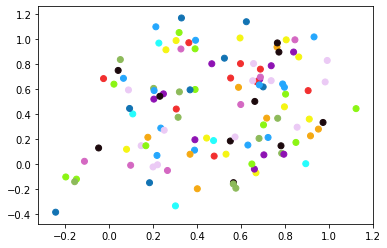

In [15]:
plt.scatter(Emb_df[0],Emb_df[1],c=Emb_df['Color'])